In [1]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

import nltk
nltk.download('omw-1.4')

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

import re
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
import string
from gensim.models import Doc2Vec  
import html
from bs4 import BeautifulSoup
from collections import Counter


# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ariesenihw\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ariesenihw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ariesenihw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Alright let's review the scraped data.

In [2]:
data = pd.read_csv("pubmed_data_full.csv")
data

,PubMedID,Title,URL,Abstract
0,37899090,Therapy with direct oral anticoagulants for se...,https://pubmed.ncbi.nlm.nih.gov/37899090,Antiphospholipid syndrome (APS) is a systemic ...
1,37878348,Treatment Outcomes With Licensed and Unlicense...,https://pubmed.ncbi.nlm.nih.gov/37878348,Stimulants (methylphenidate and amphetamines) ...
2,37866803,"AdipoRon and ADP355, adiponectin receptor agon...",https://pubmed.ncbi.nlm.nih.gov/37866803,Adiponectin replacement therapy holds the pote...
3,37864589,Exploring the logic and conducting a comprehen...,https://pubmed.ncbi.nlm.nih.gov/37864589,The potential benefits of adiponectin replacem...
4,37846549,Evaluation of pentamidine tolerability and eff...,https://pubmed.ncbi.nlm.nih.gov/37846549,Intravenous pentamidine is used for prophylaxi...
...,...,...,...,...
5832,1964663,Therapeutic application of subcutaneous low-mo...,https://pubmed.ncbi.nlm.nih.gov/1964663,Fifty patients presenting with acute deep-vein...
5833,2563187,"Relative efficacy of, and some adverse reactio...",https://pubmed.ncbi.nlm.nih.gov/2563187,Although it is a common belief that all antihy...
5834,3124679,Advanced ovarian cancer: long-term results of ...,https://pubmed.ncbi.nlm.nih.gov/3124679,To determine the efficacy of a 6-month course ...
5835,3431880,The analgesic effect of amitriptyline on chron...,https://pubmed.ncbi.nlm.nih.gov/3431880,The efficacy of amitriptyline was evaluated in...


Let's check if we have Nan's

In [3]:
rows_with_nan = data[data['Abstract'].isna() | data['Title'].isna() | data['PubMedID'].isna() | data['URL'].isna()]
rows_with_nan 

,PubMedID,Title,URL,Abstract
567,34534516,Considerations in boosting COVID-19 vaccine im...,https://pubmed.ncbi.nlm.nih.gov/34534516,NaN
677,34135024,Advancing American Kidney Health and the Role ...,https://pubmed.ncbi.nlm.nih.gov/34135024,NaN
824,33615348,New trials in the scene of cardiovascular dise...,https://pubmed.ncbi.nlm.nih.gov/33615348,NaN
840,33580678,Heart failure or heart success?,https://pubmed.ncbi.nlm.nih.gov/33580678,NaN
879,33439963,SCORED and SOLOIST: the next scores for SGLT2 ...,https://pubmed.ncbi.nlm.nih.gov/33439963,NaN
...,...,...,...,...
5749,10393496,KIGS and KIMS as tools for evidence-based medi...,https://pubmed.ncbi.nlm.nih.gov/10393496,NaN
5757,10191453,Towards evidence based emergency medicine: bes...,https://pubmed.ncbi.nlm.nih.gov/10191453,NaN
5758,10191452,Towards evidence based emergency medicine: bes...,https://pubmed.ncbi.nlm.nih.gov/10191452,NaN
5774,9597395,Should we prescribe antioxidants to patients w...,https://pubmed.ncbi.nlm.nih.gov/9597395,NaN


Alright we see 256 entries have NaN for the abstract so let's drop these.

In [4]:
data.dropna(inplace=True)
data

,PubMedID,Title,URL,Abstract
0,37899090,Therapy with direct oral anticoagulants for se...,https://pubmed.ncbi.nlm.nih.gov/37899090,Antiphospholipid syndrome (APS) is a systemic ...
1,37878348,Treatment Outcomes With Licensed and Unlicense...,https://pubmed.ncbi.nlm.nih.gov/37878348,Stimulants (methylphenidate and amphetamines) ...
2,37866803,"AdipoRon and ADP355, adiponectin receptor agon...",https://pubmed.ncbi.nlm.nih.gov/37866803,Adiponectin replacement therapy holds the pote...
3,37864589,Exploring the logic and conducting a comprehen...,https://pubmed.ncbi.nlm.nih.gov/37864589,The potential benefits of adiponectin replacem...
4,37846549,Evaluation of pentamidine tolerability and eff...,https://pubmed.ncbi.nlm.nih.gov/37846549,Intravenous pentamidine is used for prophylaxi...
...,...,...,...,...
5832,1964663,Therapeutic application of subcutaneous low-mo...,https://pubmed.ncbi.nlm.nih.gov/1964663,Fifty patients presenting with acute deep-vein...
5833,2563187,"Relative efficacy of, and some adverse reactio...",https://pubmed.ncbi.nlm.nih.gov/2563187,Although it is a common belief that all antihy...
5834,3124679,Advanced ovarian cancer: long-term results of ...,https://pubmed.ncbi.nlm.nih.gov/3124679,To determine the efficacy of a 6-month course ...
5835,3431880,The analgesic effect of amitriptyline on chron...,https://pubmed.ncbi.nlm.nih.gov/3431880,The efficacy of amitriptyline was evaluated in...


Let's inspect the top 30 most common words in the abstracts.

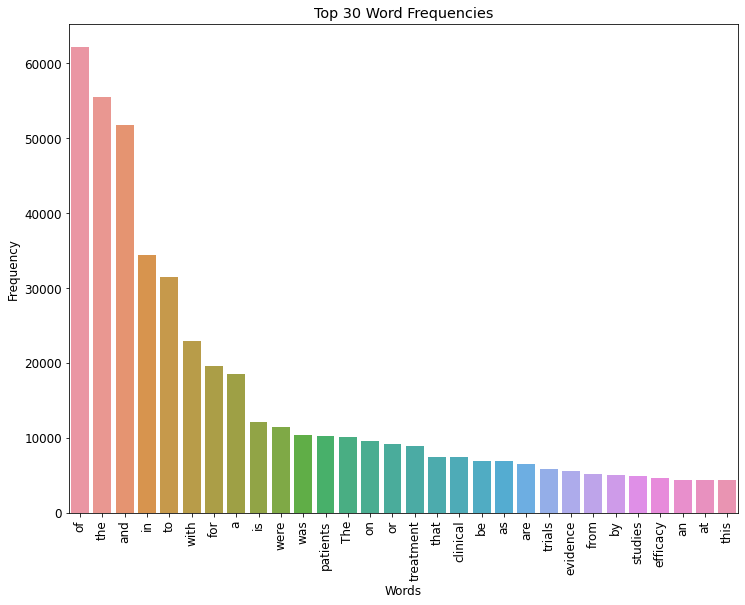

In [6]:
word_freq = {}
for sentence in data["Abstract"]:
    words = sentence.split()
    for word in words:
        if word not in word_freq:
            word_freq[word] = 1
        else: word_freq[word] += 1

df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
df_word_freq = df_word_freq.sort_values(by='Frequency', ascending=False)

# Plot the word frequencies using seaborn
sns.barplot(x=df_word_freq.index[:30], y=df_word_freq['Frequency'][:30])
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Word Frequencies')
plt.show()

As we see stopwords take up most of the spots in the 30 most recurring words. Let's remove these to paint a better picture of the 30 most common words in my corpus excluding stopwords.

In [7]:
def clean_text(text):
    if type(text) != str or text=='':
        return ''

    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"(?<=\b\w) n't", " not", text)
    text = re.sub("\'ll", " will", text)
    text = re.sub("what\'s ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("&", "and", text)
    text = re.sub("\'ve", " have ", text)
    text = re.sub(r'i\'m', 'i am', text)
    #remove stopwords and apply lemmatization instead of stemming because it is more accurate in most cases.
    stopwords_set = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [word for word in text if word.lower() not in stopwords_set]
    text = [lemmatizer.lemmatize(word) for word in text]
    
    return " ".join(text)

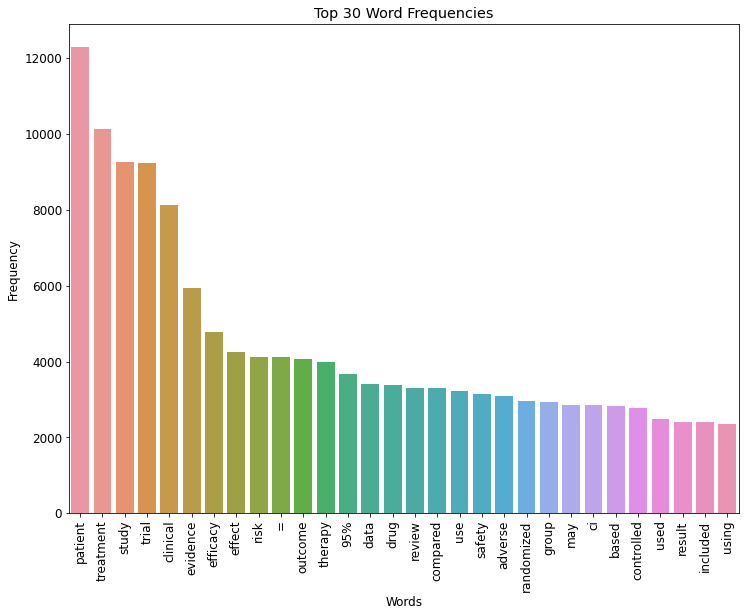

In [8]:
cleaned_data = data['Abstract'].apply(clean_text)
word_freq = {}
for sentence in cleaned_data:
    words = sentence.split()
    for word in words:
        if word not in word_freq:
            word_freq[word] = 1
        else: word_freq[word] += 1

df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
df_word_freq = df_word_freq.sort_values(by='Frequency', ascending=False)

# Plot the word frequencies using seaborn
sns.barplot(x=df_word_freq.index[:30], y=df_word_freq['Frequency'][:30])
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Word Frequencies')
plt.show()

<a name='1'></a>
## So after the cleaning function is used several things are altered or removed.
1. The text is converted to lowercase, HTML tags are removed.
3. Contractions like "n't" or "'ll" are expanded to their full form.<br>
5. Possessive forms like "'s" are removed.
6. The symbol "&" is replaced with the word "and".
8. Repeated periods are reduced to a single period.
10. Stop words are removed, and the remaining words are lemmatized.<br>
In summary the preprocessing code performs various text cleaning operations, including the removal of HTML tags, contraction expansion, and lemmatization. 
Now you can observe that the highest frequency word is not a stopword and it's frequency is only 20% of the original most frequent word "of". Now one could argue that removing stopwords is a good thing since most of them don't carry much context, which is true most of the times  and combined with lemmatization it would make the corpus and each document smaller leading to the possibility of more context to the LLM in the future. But consider the following example where I will show that some stop words do carry context and in the context of this retrieval augmented generation some stopwords could swap the whole meaning of results resulting in wrong justifications.

In [12]:
print(data['Abstract'].iloc[4])
print(cleaned_data.iloc[4])

Intravenous pentamidine is used for prophylaxis against Pneumocystis jirovecii pneumonia, an infection seen in hematopoietic stem cell transplant recipients. Pentamidine is partially metabolized by CYP2C19, which is vulnerable to pharmacogenetic variation. This retrospective study evaluated allogeneic hematopoietic stem cell transplant patients who received intravenous pentamidine as P. jirovecii pneumonia prophylaxis. The primary objective was the association between CYP2C19 phenotype and discontinuation of pentamidine due to drug-related side effects based on univariate logistic regression (N = 81). Ten patients (12.3%) discontinued pentamidine because of side effects. There was no difference in discontinuation between phenotype groups (p = 0.18) or discontinuation due to side effects (p = 0.76). Overall, no association was seen between phenotypes and pentamidine-related side effects (p = 0.475). Drug discontinuation rates and P. jirovecii pneumonia infection rates were low.
intraven

Now the first abstract is not cleaned and the second abstract is cleaned with stopwords removed and the words lemmatized. First the conclusion of a paper often contain the key findings of the research with a summary a context change here resulting from stopword removal could prove catastrophic in drug justification based on EBM where we look a results of studies to find a solution or a justification to our own problem. Now let's look at the conclusion of the original abstract where it is stated that Overall, no association was seen between phenotypes and pentamidine-related side effects (p = 0.475) and the cleaned_abstract which concludes overall, association seen phenotype pentamidine-related side effect (p = 0.475). This cleaned abstracts conclusion is the complete opposite which says there is association in side effects and giving this text as context for the LLM could result in a wrong justification of a fact based on incorrect information due to the removal of stopwords. Perhaps a more domain specific list of stopwords could be used where these kinds of "important stopwords" which don't lose context when removed are present. BUT this is only for the abstract giving context to the LLM what if I still clean the text but specifically for the embedding, even though the conclusion might be off the embedding would still match a high similarity to the fact or question needing justification and then I would retrieve the k most similar uncleaned abstracts or chuncks for the full context. For example consider the following fact needing justification or correction: pentamidine is discontinued due to drug-related side effects from stemming from the CYP2C19 phenotype would still match high similarity to the cleaned and embedded abstract with the wrong conclusion but the conclusion is irrelevant at this stage we just want to match k most similar documents for context and removing stopwords for efficient embedding and maintaining context while removing noise in the embedding could prove beneficial. Then when the k most similar abstract embeddings are matched to the question their original abstracts or chunks thereof with the correct information would would be used as context. so in summary since the primary goal in the initial step is to maximize the similarity matching for retrieval purposes, then cleaning the text by removing stopwords and irrelevant details could prove beneficial.

Proposed structure:
Chunking: First, perform chunking on the original uncleaned abstracts. This will divide each abstract into smaller sections as not to fill up the entire context window while preserving the original context. Each chunk will be stored  with an id, which can be useful for tracking.

Cleaning: After chunking the data, I would start with cleaning, for example removing stopwords. Cleaning is only for the text embeddings to remove the noise of stopwords from the embedding context to be better matched to a fact.

Embedding: Once you have cleaned the data, generate embeddings for each cleaned chunk. These will be used to calculate similarities and retrieve the most relevant original chunks when passed to the LLM for context.

tuple Structure: To maintain the link between cleaned chunks and their corresponding uncleaned versions, create a structured data format, such as a triplet. This format will take the shape of the chunk ID and the embedding of the cleaned chunk. This structure might enable me to match the cleaned chunks with questions and retrieve the uncleaned context.